### Introduction

Collaborative filtering method is a method that build a recommendation to user based on the similarity between other users.

In this notebook, we will discuss Collaborative Filtering Item-based and focuses on Model-based Approach. We will use `sklearn` and `surprise` library with KNN Nearest Neighbors model.


### Data Load

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import defaultdict

import time
import re

pd.set_option('display.max_columns', 200)

plt.style.use('bmh')

%matplotlib inline

In [2]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import the sample course dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project Bismillah/Final/Code/udemy_sample_30.csv')
df.head(3)

,id,course_id,rate,date,display_name,comment,title,is_paid,price,headline,num_subscribers,avg_rating,num_reviews,num_comments,num_lectures,content_length_min,published_time,last_update_date,category,subcategory,topic,language,course_url,instructor_name,instructor_url,image
0,24371058,1285808,5.0,2018-12-11T20:50:07-08:00,Solihu Gaffar,Well has a beginner things are getting clearer...,Java for Complete Beginners,True,19.99,The Course Where Programming and Fun Meet! Lea...,43631,4.250000,3137,568,43,376,2017-10-30 23:37:17+00:00,2020-12-07,Development,Programming Languages,Java,English,/course/java-for-complete-beginners/,Rupal T,/user/rupal-totale/,https://img-b.udemycdn.com/course/750x422/1285...
1,10287048,1049154,3.0,2017-10-16T06:46:18-07:00,Mark,The pause functionality does not repond,SAP Financial Accounting and Controlling Super...,True,69.99,A complete Beginner and Intermediate SAP FICO ...,5526,4.315790,1110,219,23,379,2016-12-27 16:41:23+00:00,2018-02-02,Office Productivity,SAP,SAP Financial Accounting,English,/course/sap-financial-accounting-and-controlli...,SAP Academy,/user/sadim-rasheed-3/,https://img-c.udemycdn.com/course/750x422/1049...
2,16934964,874012,5.0,2018-05-25T21:22:46-07:00,Nilaksh,Very good one but when you will teach sketch.,The Ultimate Drawing Course - Beginner to Adva...,True,149.99,Learn the #1 most important building block of ...,490520,4.619531,115533,22341,65,669,2017-01-23 00:20:05+00:00,2022-03-16,Design,Graphic Design & Illustration,Drawing,English,/course/the-ultimate-drawing-course-beginner-t...,Jaysen Batchelor,/user/jaysen-batchelor/,https://img-c.udemycdn.com/course/750x422/8740...


## Recommendation System - Collaborative Filtering

This section will be our processes to get the recommendation. There are two approaches that we want to do

1. Get the similar courses after the user input what course that they want to watched
2. Give recommendation for the user based on historical watched

Also, we will use 2 libraries to extract the similarity information and get the recommendation; `sklearn` and `surprise` libraries

### 1. KNN Recommender System - sklearn

In [5]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (user_name, course_id, rate)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        course_mapper: dict that maps course id's to course indices
        course_inv_mapper: dict that maps course indices to course id's
    """

    M = df['user_name'].nunique()
    N = df['course_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_name"]), list(range(M))))
    course_mapper = dict(zip(np.unique(df["course_id"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user_name"])))
    course_inv_mapper = dict(zip(list(range(N)), np.unique(df["course_id"])))

    user_index = [user_mapper[i] for i in df['user_name']]
    item_index = [course_mapper[i] for i in df['course_id']]

    X = csr_matrix((df["rate"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, course_mapper, user_inv_mapper, course_inv_mapper

In [6]:
df = df.rename(columns={'display_name' : 'user_name'})

course_data = df[['user_name', 'course_id', 'rate']]

X, user_mapper, course_mapper, user_inv_mapper, course_inv_mapper = create_X(course_data)

In [7]:
X.shape

(31860, 17810)

In [8]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.01%


In [9]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

31860

In [10]:
print(f"Most active user rated {n_ratings_per_user.max()} courses.")
print(f"Least active user rated {n_ratings_per_user.min()} courses.")

Most active user rated 993 courses.
Least active user rated 1 courses.


In [11]:
n_ratings_per_course = X.getnnz(axis=0)
len(n_ratings_per_course)

17810

In [12]:
print(f"Most rated course has {n_ratings_per_course.max()} ratings.")
print(f"Least rated course has {n_ratings_per_course.min()} ratings.")

Most rated course has 500 ratings.
Least rated course has 1 ratings.


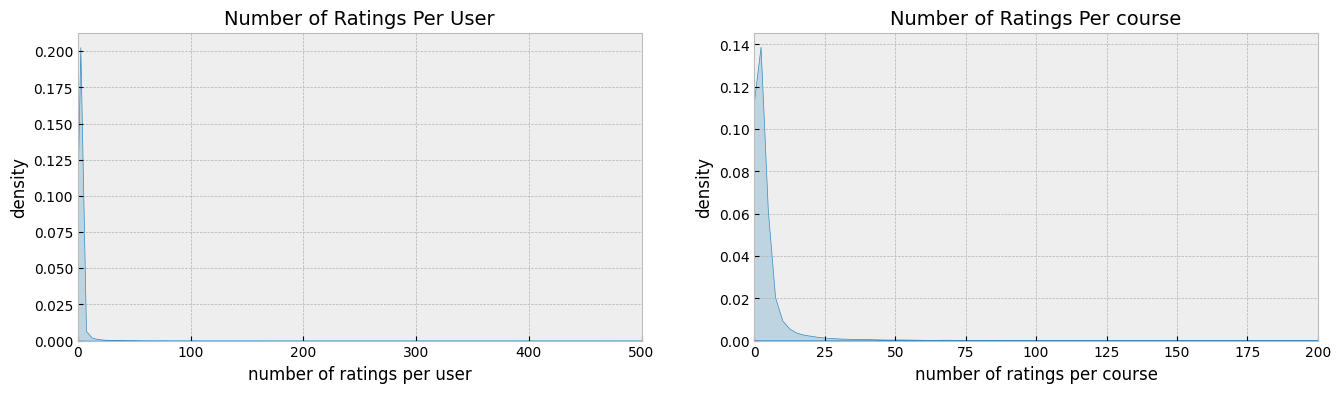

In [13]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0, 500)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_course, shade=True)
plt.xlim(0, 200)
plt.title("Number of Ratings Per course", fontsize=14)
plt.xlabel("number of ratings per course")
plt.ylabel("density")
plt.show()

In [14]:
from sklearn.neighbors import NearestNeighbors

def find_similar_courses(course_id, X, course_mapper, course_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given course id.

    Args:
        movie_id: id of the course of interest
        X: user-item utility matrix
        k: number of similar course to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar course ID's
    """
    X = X.T
    neighbour_ids = []

    course_ind = course_mapper[course_id]
    course_vec = X[course_ind]
    if isinstance(course_vec, (np.ndarray)):
        course_vec = course_vec.reshape(1,-1)

    # use k+1 since kNN output includes the course id of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(course_vec, return_distance=False)

    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(course_inv_mapper[n])
    neighbour_ids.pop(0)

    return neighbour_ids

In [15]:
# searching for the title of interest; give 10 nearest titles
unique_title = df.drop_duplicates(subset='title').reset_index(drop=True)[['course_id', 'title']]

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(unique_title['title'])

In [17]:
def search(title):
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = unique_title.iloc[indices].iloc[::-1]

    return results.reset_index(drop=True)

In [18]:
searching = search('Machine Learning')
searching

,course_id,title
0,3914652,2022 Machine Learning A to Z : 5 Machine Learn...
1,1568060,Machine Learning In The Cloud With Azure Machi...
2,1088256,DP-100: A-Z Machine Learning using Azure Machi...
3,1955654,Machine Learning with Javascript
4,3288036,Machine Learning & Deep Learning in Python & R


In [19]:
num = 2
course_id = searching.iloc[num]['course_id']
similar_courses = find_similar_courses(course_id, X, course_mapper, course_inv_mapper, metric='cosine', k=10)

In [20]:
course_mapping = dict(zip(df['course_id'], df['title']))

In [21]:
course_title = searching.iloc[num]['title']

In [22]:
print(f"Because you watched {course_title}:")
print()
for i in similar_courses:
    print(course_mapping[i])

Because you watched DP-100: A-Z Machine Learning using Azure Machine Learning:

UX Design intro. User Experience Design Fundamentals.
Algorithmic Trading with Python: Technical Analysis Strategy
Guaranteed weight loss and Fitness with lifestyle changes
Oracle Analytic Functions In-Depth & Advanced Oracle SQL
Microgreens MasterClass Business Approach
Basics of Indian Customs Act A Complete Study
Mastering SQL Server Reporting Services (SSRS) From Scratch
MECM : Operating System Deployment Training : SCCM
The Complete Raspberry Pi Bootcamp


### 2. KNN with Means Recommender System - surprise

In [23]:
## Install Surprise
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357247 sha256=c3c3bfb1f18280dada640dce884493a1b7b710a475512a9c51736122fe335c0e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [24]:
import os

from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic, KNNWithMeans

from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae

from surprise import dump

In [25]:
# the model takes 3 features; id, course_id
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(course_data, reader)

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [26]:
# item-based approach
sim_options = {'name' : 'cosine',
               'user_based' : False}

# KNN with means; means of rating
knn = KNNWithMeans(k=5, sim_options=sim_options, verbose=True)
knn.fit(train_data)

predictions = knn.test(test_data)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [28]:
rmse(predictions, verbose=True)

RMSE: 0.9213


0.9212748505758273

In [29]:
mae(predictions, verbose=True)

MAE:  0.6256


0.6255762917069154

In [30]:
def get_top_n(predictions, user_name, course_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns:

    '''
    #Peart I.: Surprise docomuntation

    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]

    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/

    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.user_name == (user_name)]
    print('User {0} has already rated {1} courses.'.format(user_name, user_data.shape[0]))


    #4. Data Frame with predictions.
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                            columns=["user_name" ,"course_id","rat_pred"])


    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres.
    pred_usr = preds_df[preds_df["user_name"] == (user_name)].merge(course_df, how = 'left',
                                                                    left_on = 'course_id', right_on = 'course_id')

    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.user_name == (user_name) ].sort_values("rate", ascending = False).merge\
    (course_df, how = 'left', left_on = 'course_id', right_on = 'course_id')


    return hist_usr, pred_usr

In [31]:
course_data.head()

,user_name,course_id,rate
0,Solihu Gaffar,1285808,5.0
1,Mark,1049154,3.0
2,Nilaksh,874012,5.0
3,Harshit,1255136,4.0
4,Nagmani,1209412,3.5


In [32]:
course_df = df[['course_id', 'title', 'headline', 'category', 'subcategory', 'topic']]
course_df = course_df.drop_duplicates(subset='course_id')

In [33]:
hist_user, pred_usr = get_top_n(predictions, 'Brooke' , course_df, course_data, n = 10)

User Brooke has already rated 10 courses.


In [34]:
hist_user.head()

,user_name,course_id,rate,title,headline,category,subcategory,topic
0,Brooke,1516674,5.0,Graphic Design Foundations in Canva: Theory an...,Learn design theory and practice GREAT graphic...,Design,Graphic Design & Illustration,Graphic Design
1,Brooke,1355694,5.0,Video Editing with Adobe Premiere Pro for Corp...,"In this Adobe Premiere Pro course, we’ll edit ...",Business,Media,Adobe Premiere
2,Brooke,1107110,5.0,"eCommerce Website: Shopify, Dropshipping, Amaz...",Beginner Introduction to eCommerce through Sho...,Business,E-Commerce,WooCommerce
3,Brooke,613808,5.0,Leadership: Practical Leadership Skills,Master leadership skills and leadership techni...,Business,Management,Leadership
4,Brooke,1248672,5.0,Google Certified Educator Level 1 Technical Tr...,Google Apps for Education,Office Productivity,Google,Google Certified Educator


In [35]:
pred_usr

,user_name,course_id,rat_pred,title,headline,category,subcategory,topic
0,Brooke,248826,4.917895,Introduction to CBT: Cognitive Behavioral Therapy,Online Counselling & Cognitive Behavioural The...,Health & Fitness,Mental Health,CBT Cognitive Behavioral Therapy
1,Brooke,857982,4.848235,Powerpoint Presentation - design powerpoint sl...,Learn to Design powerpoint slides for presenta...,Office Productivity,Microsoft,PowerPoint
2,Brooke,613808,4.832265,Leadership: Practical Leadership Skills,Master leadership skills and leadership techni...,Business,Management,Leadership
3,Brooke,1107110,4.507570,"eCommerce Website: Shopify, Dropshipping, Amaz...",Beginner Introduction to eCommerce through Sho...,Business,E-Commerce,WooCommerce
4,Brooke,1248672,4.500000,Google Certified Educator Level 1 Technical Tr...,Google Apps for Education,Office Productivity,Google,Google Certified Educator


In [36]:
def retrieve_courses(model, course_id):

    course_dict = dict(zip(df['title'], df['course_id']))
    id_dict = dict(zip(df['course_id'], df['title']))

    inner_id = model.trainset.to_inner_iid(course_id)
    neighbors_item = model.get_neighbors(inner_id, k=10)

    # Convert inner ids of the neighbors into names.
    neighbors_name = (
        model.trainset.to_raw_iid(iid) for iid in neighbors_item
    )

    course_neighbors = (id_dict[rid] for rid in neighbors_name)

    return course_neighbors

In [37]:
num = 2
course_id = searching.iloc[num]['course_id']

In [38]:
generate_neighbors = retrieve_courses(knn, course_id)

for n in generate_neighbors:
    print(n)

Java Programming Masterclass covering Java 11 & Java 17
MECM : Operating System Deployment Training : SCCM
Automate the Boring Stuff with Python Programming
Apache Kafka Series - Learn Apache Kafka for Beginners v3
Cryptocurrency Investment Course 2022: Fund your Retirement!
Learn Swagger and the Open API Specification
Angular - The Complete Guide (2022 Edition)
Music Theory Comprehensive Complete! (Parts 1, 2, & 3)
The Complete Financial Analyst Training & Investing Course
Master Java Web Services and REST API with Spring Boot
